In [2]:
import scipy.io as sio
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy import linalg as LA
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import sys
import importlib
%matplotlib notebook


In [3]:
# helper visualization functions

def visualize_2d(X,labels):
    u,sig,v = LA.svd(X)
    d2 = X.dot(v.T[:,0:2])
    fig = plt.figure()
    plt.scatter(d2[:,0],d2[:,1],c=labels[0])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
def visualize_3d(X,labels):
    u,sig,v = LA.svd(X)
    d3 = X.dot(v.T[:,0:3])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(d3[:,0],d3[:,1],d3[:,2],c=labels[0] if labels is not None else 'r')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.show()
    
def centralize(X):
    X = X - X.mean(axis=0)
    return X
    

# Problem 1

In [693]:
# Problem 1
#Problem 1a

# load the data matrix X
d_jest = sio.loadmat('jesterdata.mat')
X = d_jest['X']
#X = centralize(X)
# load known ratings y and true ratings truey
d_new = sio.loadmat('newuser.mat')
y = d_new['y']
true_y = d_new['truey']

# total number of joke ratings should be m = 100, n = 7200
m, n = X.shape

# Problem 1a

<IPython.core.display.Javascript object>


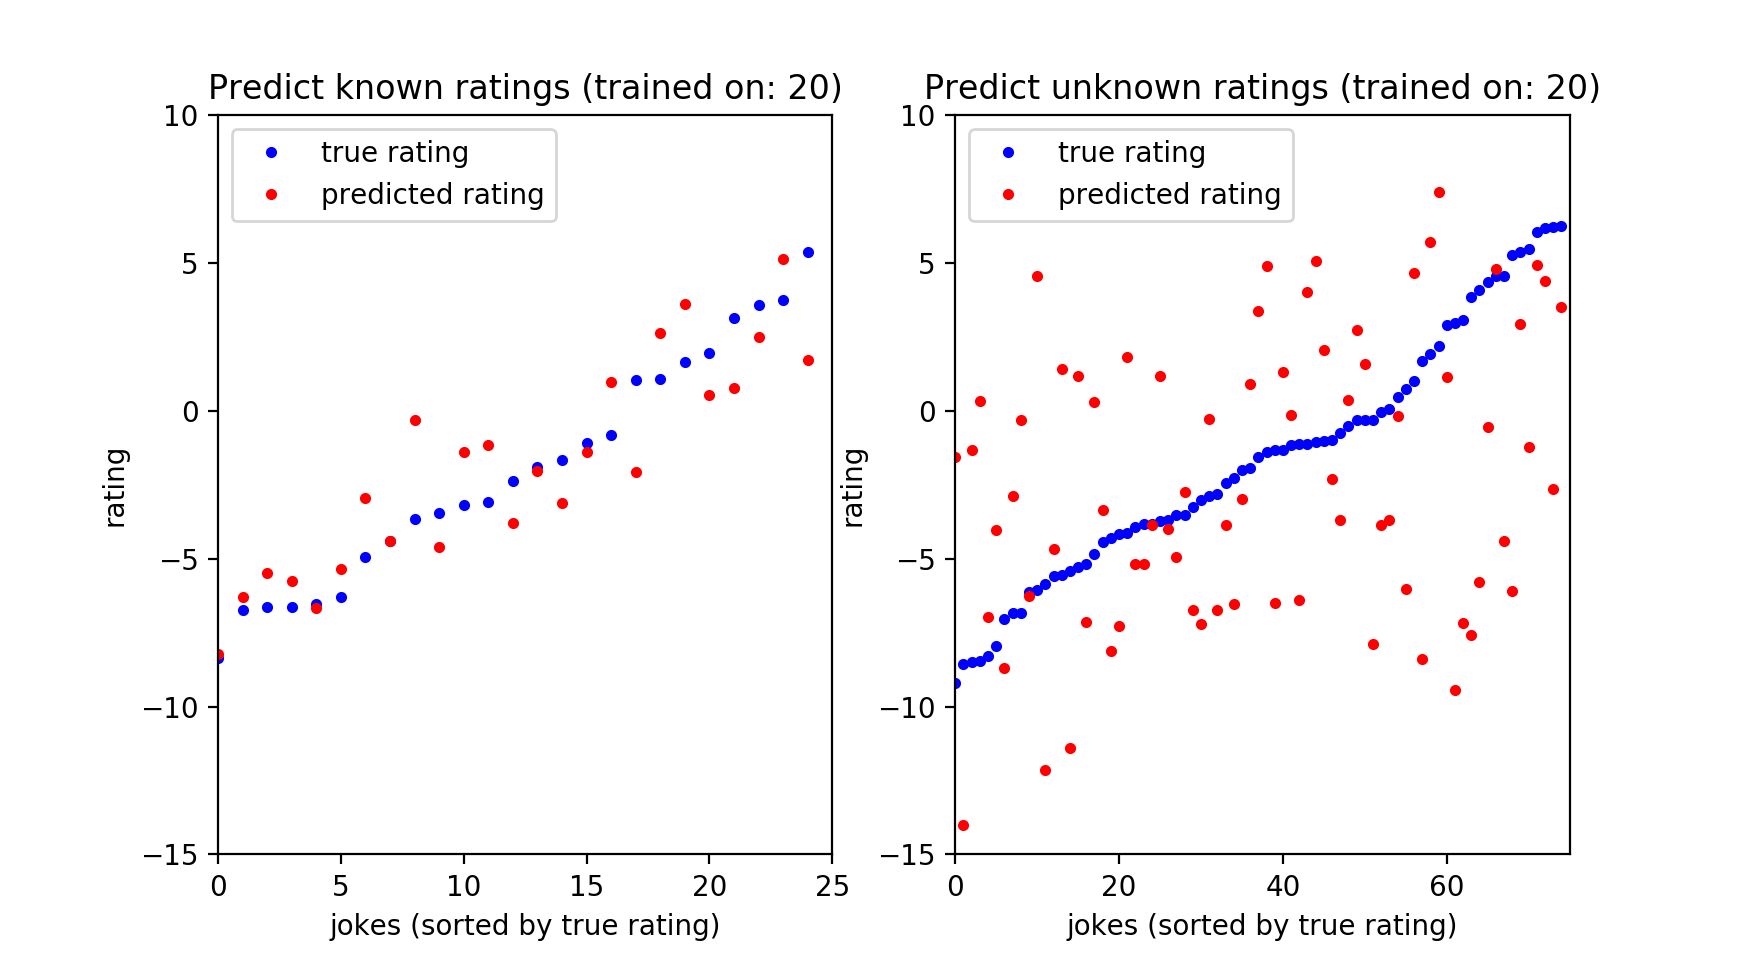

Average l_2 error (train) in ratings squared: 2.954026477001232
Average l_2 (test) in ratings squared: 28.750050107926526


In [617]:


# train on ratings we know for the new user
train_indices = np.squeeze(y != -99)
num_train = np.count_nonzero(train_indices)

# test on ratings we don’t know
test_indices = np.logical_not(train_indices)
num_test = m - num_train
X_data = X[train_indices, 0:20]
y_data = y[train_indices]
y_test = true_y[test_indices]
X_test = X[test_indices,0:20]

#solve for weights
w_hat = least_squares(X_data,y_data)

# compute predictions
y_hat_train = np.dot(X_data,w_hat)
y_hat_test = np.dot(X_test,w_hat)

# measure performance on training jokes
avgerr_train =  np.sum(np.square(np.subtract(y_data,y_hat_train)))/num_train

# print(X_test.shape)
# print(w_hat.shape)
# print(y_hat.shape)
# print(y_hat_test.shape)
# print(y_hat_train.shape)
# print(X_data.shape)
# print(y_data.shape)
# print(y_data)
# print(np.subtract(y_data,y_hat_train).shape)

# display results
ax1 = plt.subplot(121)
sorted_indices = np.argsort(np.squeeze(y_data))
ax1.plot(range(num_train), y_data[sorted_indices],'b.', range(num_train), y_hat_train[sorted_indices], 'r.' )
ax1.set_title('Predict known ratings (trained on: 20)')
ax1.set_xlabel('jokes (sorted by true rating)')
ax1.set_ylabel('rating')
ax1.legend(['true rating', 'predicted rating'], loc ='upper left')
ax1.axis([0, num_train, -15, 10])
print("Average l_2 error (train) in ratings squared:", avgerr_train)

# measure performance on unrated jokes
avgerr_test =  np.sum(np.square(np.subtract(y_test,y_hat_test)))/num_test

# display results
ax2 = plt.subplot(122)
sorted_indices = np.argsort(np.squeeze(y_test))
ax2.plot(range(num_test), y_test[sorted_indices], 'b.',range(num_test), y_hat_test[sorted_indices], 'r.' )
ax2.set_title('Predict unknown ratings (trained on: 20)')
ax2.set_xlabel('jokes (sorted by true rating)')
ax2.set_ylabel('rating')
ax2.legend(['true rating', 'predicted rating'], loc ='upper left')
ax2.axis([0, num_test, -15, 10])
print("Average l_2 (test) in ratings squared:", avgerr_test)
plt.show()

The predictor seems to be rather bad. Perhaps least squares is not functioning properly (there is a lot of noise that could be messing it up, and not much data to train on.

# Problem 1b

Now that the problem is underdetermined, normal least squares will not work. Least squares using the SVD will be necessary. The code for this will utilize a function in question two, where the truncating is done on 0 elements.

<IPython.core.display.Javascript object>


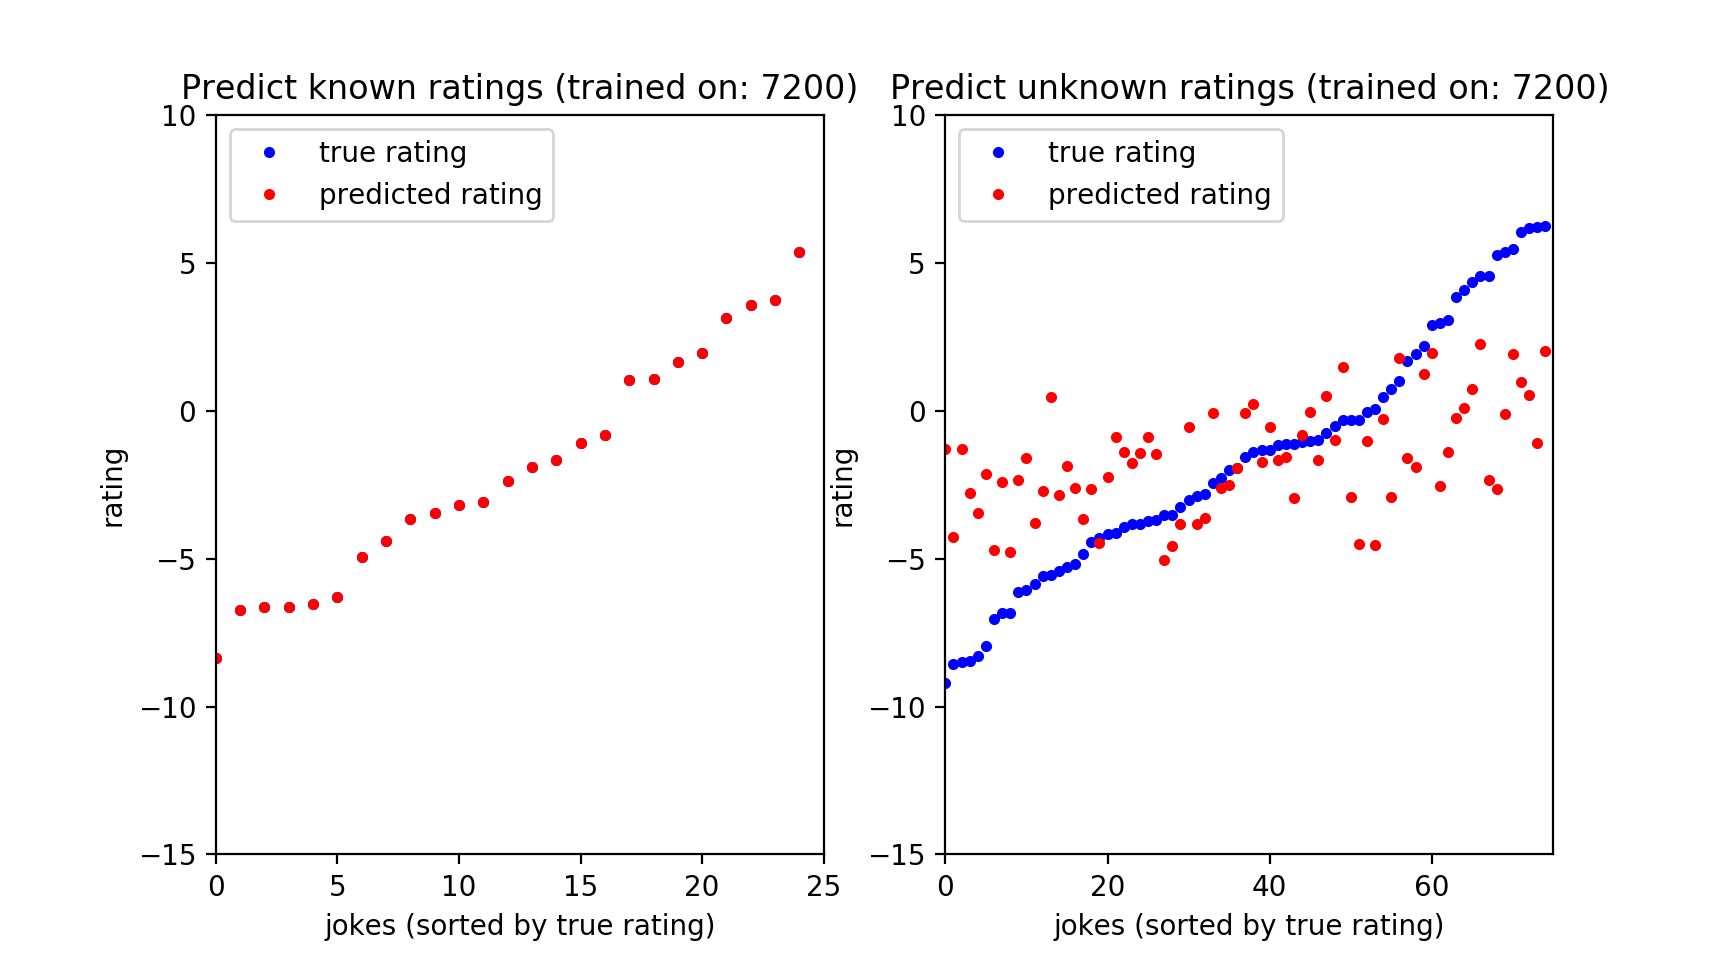

Average l_2 error (train) in ratings squared: 1.223819086837247e-28
Average l_2 (test) in ratings squared: 12.21052375094272


In [618]:
# Problem 1b

# test on ratings we don’t know
test_indices = np.logical_not(train_indices)
num_test = m - num_train
X_data = X[train_indices,:] #use whole matrix!
y_data = y[train_indices]
y_test = true_y[test_indices]
X_test = X[test_indices,:]

#solve for weights
u,sig,v = LA.svd(X_data, full_matrices=False)
w_hat = truncated_svd_w(u,sig,v,len(sig)).dot(y_data)

# compute predictions
y_hat_train = np.dot(X_data,w_hat)
y_hat_test = np.dot(X_test,w_hat)

# measure performance on training jokes
avgerr_train =  np.sum(np.square(np.subtract(y_data,y_hat_train)))/num_train


# display results
ax1 = plt.subplot(121)
sorted_indices = np.argsort(np.squeeze(y_data))
ax1.plot(range(num_train), y_data[sorted_indices],'b.', range(num_train), y_hat_train[sorted_indices], 'r.' )
ax1.set_title('Predict known ratings (trained on: 7200)')
ax1.set_xlabel('jokes (sorted by true rating)')
ax1.set_ylabel('rating')
ax1.legend(['true rating', 'predicted rating'], loc ='upper left')
ax1.axis([0, num_train, -15, 10])
print("Average l_2 error (train) in ratings squared:", avgerr_train)

# measure performance on unrated jokes
avgerr_test =  np.sum(np.square(np.subtract(y_test,y_hat_test)))/num_test

# display results
ax2 = plt.subplot(122)
sorted_indices = np.argsort(np.squeeze(y_test))
ax2.plot(range(num_test), y_test[sorted_indices], 'b.',range(num_test), y_hat_test[sorted_indices], 'r.' )
ax2.set_title('Predict unknown ratings (trained on: 7200)')
ax2.set_xlabel('jokes (sorted by true rating)')
ax2.set_ylabel('rating')
ax2.legend(['true rating', 'predicted rating'], loc ='upper left')
ax2.axis([0, num_test, -15, 10])
print("Average l_2 (test) in ratings squared:", avgerr_test)
plt.show()




# Problem 1c

To find a user that gives good predictions for a new user, we can compute a weight vector using this new user, and take the top weight (or two weights) in magnitude. The position of these weights in the weight vector corresponds to the user(s) in the data that most strongly correspond to the new user, and so these users can be found.


In [661]:
# Problem 1c: code portion

def find_weights(X_data,y_data):
    #solve for weights
    u,sig,v = LA.svd(X_data, full_matrices=False)
    w_hat = truncated_svd_w(u,sig,v,len(sig)).dot(y_data)
    return w_hat

def find_best_match(w_hat):
    wh_search = np.absolute(w_hat)

    wh_sorted = np.sort(wh_search,0)[::-1][0:2]
    top = wh_sorted[0]
    second = wh_sorted[1]

    wh_searchable = list(wh_search)

    # compute best two users
    best = []
    best.append(wh_searchable.index(top))
    best.append(wh_searchable.index(second))
    
    return best

# Test 1: Use existing users, see if it finds that user to be best
accuracy = []
secs = []
N = 100
for i in range(N):
    index = np.random.randint(0,7200)
    test_user = X[:,index]
    w_hat_test = find_weights(X,test_user)
    best_test = find_best_match(w_hat_test)
    accuracy.append(1 if best_test[0] == index else 0)
    secs.append(1 if best_test[1] == index else 0)

mean_top = np.mean(accuracy)
mean_sec = np.mean(secs)
print("Fraction matching to top user in {} trials: {}".format(N,mean_top))
print("Fraction matching to second user in {} trials: {}".format(N,mean_sec))
print("Total Accuracy as finding user in top two for {} trials: {}".format(N,mean_top + mean_sec))
    


Fraction matching to top user in 100 trials: 0.99
Fraction matching to second user in 100 trials: 0.0
Total Accuracy as finding user in top two for 100 trials: 0.99


From the above, it seems that this method of finding similar uses is quite accurate. Let's apply it to the new user. For this trial, we will find the top two users, then compute a predicted value using these two, and report the error. If the users properly represent the new user, then the predicted values should have a low error (even though the data set is small

In [677]:
# Problem 1c continued:

# find two best users
best = find_best_match(w_hat)

print("Best users are: {} and {}".format(best[0],best[1]))

X_match = X[:,best]
w_match = find_weights(X_match,y)

# compute ratings on small dataset
y_match_hat = np.dot(X_match,w_match)
avgerr_small = np.sum(np.square(np.subtract(true_y,y_match_hat)))/len(y_match_hat)

# to compare, find random selection of users and compare to that error
err_bad = []
for i in range(10):
    bad = [np.random.randint(0,7200),np.random.randint(0,7200)]
    X_bad = X[:,bad]
    w_bad = find_weights(X_bad,y)
    y_bad_hat = np.dot(X_bad,w_bad)
    err_bad.append(np.sum(np.square(np.subtract(true_y,y_bad_hat)))/len(y_bad_hat))


print("Average error in squared units on small dataset: {}".format(avgerr_small))
print("Average error in squared units on random dataset (10 trials): {}".format(np.mean(err_bad)))


Best users are: 2502 and 499
Average error in squared units on small dataset: 72.25910918331911
Average error in squared units on random dataset (10 trials): 2717.6995264663888


The above shows that the best users are user 2502 and 499.
Additionally, I computed the average error in squared units using this tiny, well tuned data set, against a dataset of a similar size that was chosen at random, repeated 10 times. This shows that our very small dataset of similar users gives a much better prediction than a random dataset of a similar size (as expected).

# Problem 1d

The rank of X is: 100


<IPython.core.display.Javascript object>


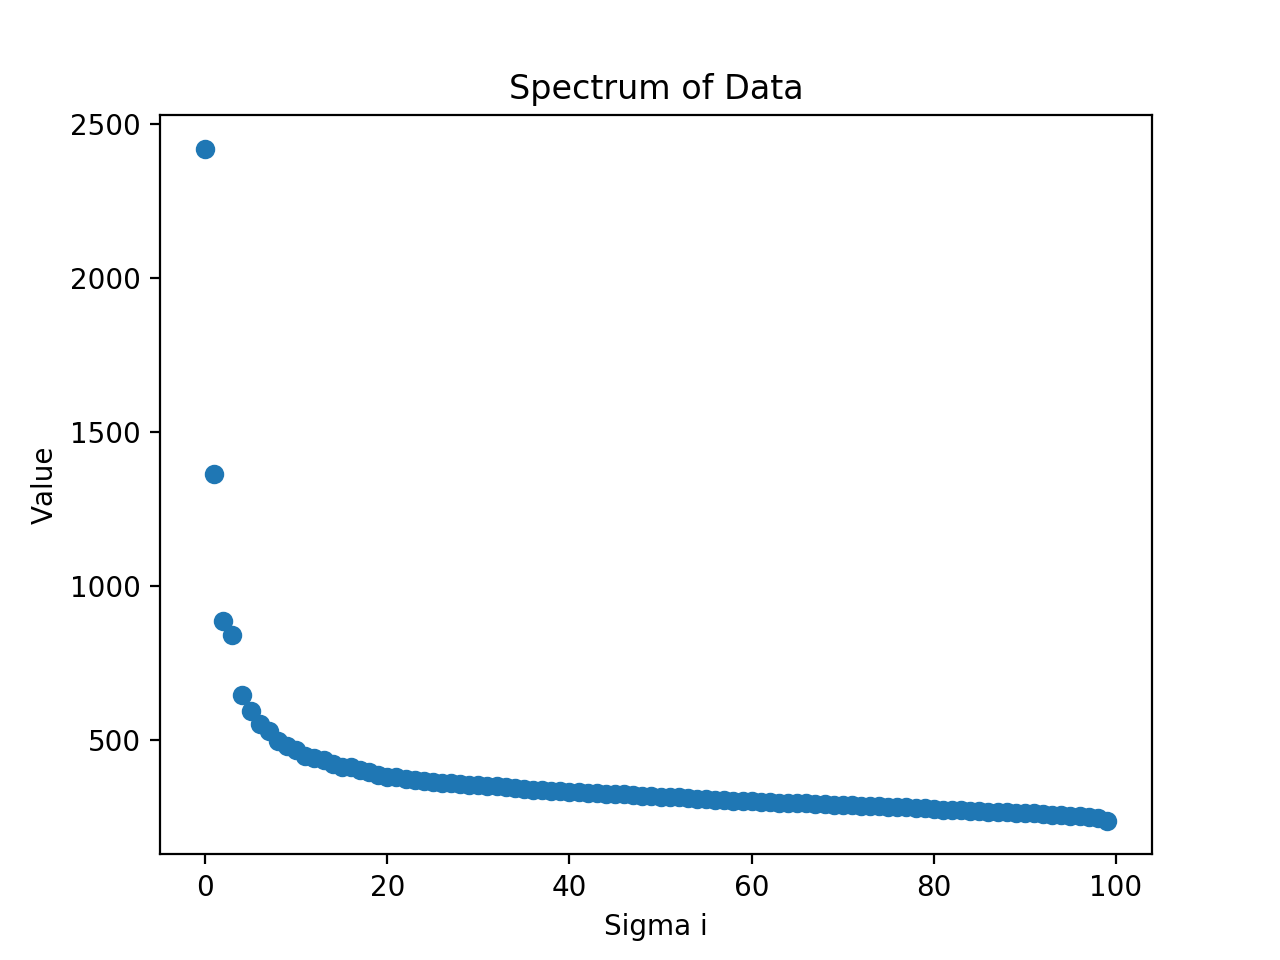

In [551]:
# Problem 1d

u,sig,v = LA.svd(X,full_matrices=False)
print("The rank of X is: {}".format(len(sig)))
fig = plt.figure()
plt.scatter(list(range(0,len(sig))),sig)
plt.title("Spectrum of Data")
plt.xlabel("Sigma i")
plt.ylabel("Value")
plt.show()




X is full rank.
However, the first four principal components appear to be significantly more pertinent than others, so these dimensions are the most important. 

This means that there are a few users that are representative of the majority of users.


# Problem 1e

<IPython.core.display.Javascript object>


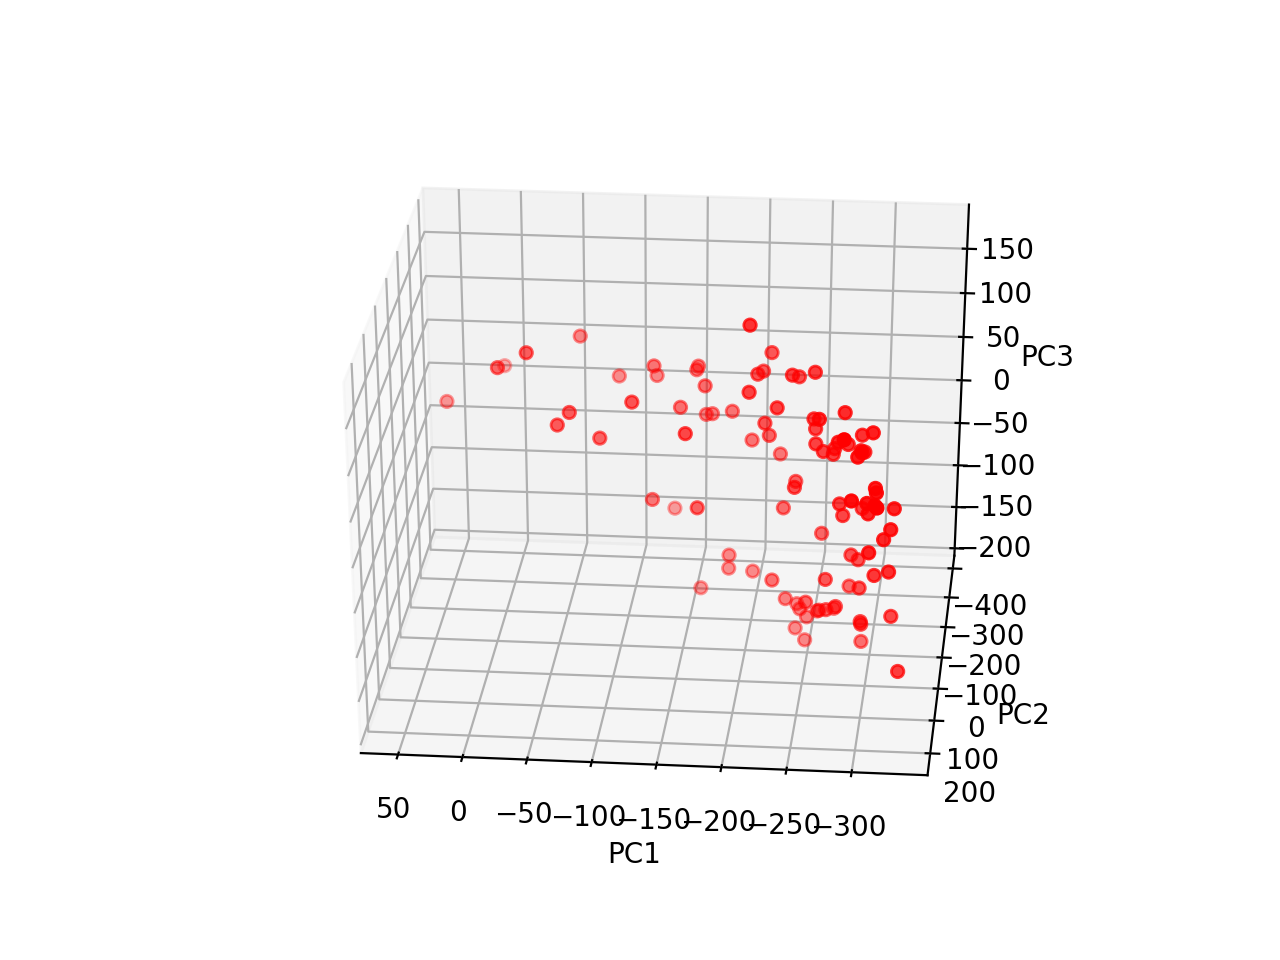

In [552]:
# Problem 1e

visualize_3d(X,None)



The structure shows a sort of clustering around a single plane, showing that the data could be represented decently well in lower dimensions. This means that groups of users are rating jokes similarly to each other, showing that there may be only a few distinct senses of humor present in the dataset. This correlation is not particularly strong, and there are a few points that lie outside this plane, but it is a start.

# Problem 1f: compute Power Iteration

The power iteration works by starting with an intial guess at the first eigenvector, and then through repeated multiplication with the matrix (and normalization of that vector), a very good approximation of the first eigenvector is found.

In this method, it is assumed that one eigenvalue will be much greater than the others, and the starting guess does not have a 0 that corresponds to that large eigenvalue. As the number of iterations goes towards infinity, the multiplication of those other eigenvalues (less than 1) tends towards zero. This sequence of vectors truly converges if the largest eigenvector is equal to one (and the rest are less than zero).


In [604]:
# Problem 1f: Power Iteration code

def power_iterate(A, epsilon):
    
    #initial random guess
    pi = np.random.rand(A.shape[1])
    distance = 100

    while distance > epsilon:
        # calculate the matrix-by-vector product Ab
        pi_old = pi
        
        pi_next = np.dot(A, pi)

        # calculate the norm
        pi_next_norm = LA.norm(pi_next)
        
        # re normalize the vector
        pi = pi_next / pi_next_norm
        
        distance = LA.norm(pi - pi_old)
        
    return pi

pi = power_iterate(np.dot(X,X.T),0.00000005)
u,sig,v = LA.svd(X)
d = np.sum(np.square(np.subtract(u[:,0],pi)))/len(pi)
print("Distance (avg squared error) between Power Iteration vector and first column of U: {}".format(d))

Distance (avg squared error) between Power Iteration vector and first column of U: 0.03999999999999999


As the distance between the power iteration vector on XX^T and the first column of U is very small, it seems the power iteration has done a very good approximation of the first eigenvector.

# Problem 1g: Power Iteration problems

Two potential issues with the starting vector: 
1: A starting vector that would fail to find the right vectors would have a 0 where there should not be.
Because of the multiplicative nature of the power iteration, an initial 0 would never change.
So a particularly bad starting place would be a vector of zeros
2: A vector whose norm is 0 would cause a divide by zero error


# Problem 2: Face Emotion Data, revisited

In [554]:
# Problem 2

d = sio.loadmat('face_emotion_data.mat') 
X = d['X']
y = d['y']


# Problem 2a: Truncated SVD

In [361]:
def truncated_svd_w(u,sig,v,k):
    sig_inv = sig
    for i in range(k):
        if sig_inv[i] != 0:
            sig_inv[i] = 1/sig_inv[i] 
    for j in range(k,len(sig_inv)):
        sig_inv[j] = 0
    
    sig_inv = np.diag(sig_inv)
    return np.dot(v.T,sig_inv).dot(u.T)

In [16]:
# Problem 2a:
def trunc_SVD_learn(X,y,sets,set_size):

    total_errs = []
    k_vals = []

    for i in range(sets):
        # pick hold out set
        ih = np.arange(set_size*i , set_size * (i+1))

        Xh = X[ih, :]
        yh = y[ih, :]

        # store the error rates for each error set
        err_rate = np.array(0)

        for j in range (sets):
            # to ensure different hold out sets
            if j == i: 
                continue
            # ih is the set of error indices
            ie = np.arange(set_size * j  , set_size * (j+1))

            #remove is range of held out and test data, to be taken out for training
            remove = np.concatenate((ih,ie))

            #training sets
            Xt = np.delete(X,remove,0)
            yt = np.delete(y,remove,0)

            # error set
            Xe = X[ie, :]
            ye = y[ie, :]

            # truncated SVD solution
            k_error = np.zeros((9))
            k_w_hats = np.empty(9, dtype=object)
            for k in range(1,10):
                u,sig,v = LA.svd(Xt, full_matrices=False)
                w = truncated_svd_w(u,sig,v,k)
                w_hat = np.dot(w,yt)
                k_w_hats[k-1] = w_hat
                ypk = np.sign(np.dot(Xe,w_hat))
                k_error[k-1] = np.mean(ypk != ye)
            best_k = np.argmin(k_error)
            k_vals.append(best_k+1)
            best_w_hat = k_w_hats[best_k]

            # compute the error rate for this experiment
            yp = np.sign(np.dot(Xh, best_w_hat))
            total_errs = np.append(total_errs,np.mean(yp != yh))
    
    return np.mean(total_errs),k_vals
        
#NOTE: should be around 11% error

avg_err,ks = trunc_SVD_learn(X,y,8,16)
print("Average error Truncated SVD: {}".format(avg_err))
print("Best k values for each trial: {}".format(ks))


Average error Truncated SVD: 0.11160714285714286
Best k values for each trial: [4, 5, 5, 5, 1, 4, 4, 5, 7, 5, 2, 1, 4, 5, 5, 2, 5, 2, 1, 4, 5, 9, 4, 5, 2, 1, 4, 5, 6, 4, 5, 6, 2, 4, 5, 4, 4, 4, 6, 2, 4, 4, 8, 4, 5, 6, 2, 1, 5, 4, 4, 4, 5, 2, 1, 4]


# Problem 2b: Ridge Regression

In [266]:
def ridge_regression(X,y,lam):
    I = np.identity(X.shape[1])
    lam_array = lam * I
    square = np.dot(X.T,X)
    inversion = LA.inv(square + lam_array)
    return np.dot(inversion,X.T).dot(y)

In [18]:
# Problem 2b

def ridge_regression_learn(X,y,sets,set_size):
    total_errs = []
    lams = []
    
    for i in range(sets):
        # pick hold out set
        ih = np.arange(set_size*i , set_size * (i+1))

        Xh = X[ih, :]
        yh = y[ih, :]

        # store the error rates for each error set
        err_rate = np.array(0)

        for j in range (sets):
            # to ensure different hold out sets
            if j == i: 
                continue
            # ih is the set of error indices
            ie = np.arange(set_size * j  , set_size * (j+1))

            #remove is range of held out and test data, to be taken out for training
            remove = np.concatenate((ih,ie))

            #training sets
            Xt = np.delete(X,remove,0)
            yt = np.delete(y,remove,0)

            n, p = np.shape(Xt)

            # error set
            Xe = X[ie, :]
            ye = y[ie, :]

            # ridge regression
            lambda_vals = np.array([0, 0.5, 1, 2, 4, 8, 16])
            k_error = np.zeros((7))
            k_w_hats = np.empty(7, dtype=object)
            for k in range(7):
                w_hat = ridge_regression(Xt,yt,lambda_vals[k])
                k_w_hats[k-1] = w_hat
                ypk = np.sign(np.dot(Xe,w_hat))
                k_error[k] = np.mean(ypk != ye)
            best_lam = np.argmin(k_error)
            best_w_hat = k_w_hats[best_lam]
            lams.append(lambda_vals[best_lam])

            # compute the error rate for this experiment
            yp = np.sign(np.dot(Xh, best_w_hat))
            total_errs = np.append(total_errs,np.mean(yp != yh))

    return np.mean(total_errs),lams

avg_err,lams = ridge_regression_learn(X,y,8,16)
print("Average Error on Ridge Regression: {}".format(avg_err))
print("Best Lambda value for each trial: {}".format(lams))

Average Error on Ridge Regression: 0.04575892857142857
Best Lambda value for each trial: [0.0, 8.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 16.0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 0.0, 0.0]


# Problem 2c

In [156]:
# Problem 2c

# adding random combinations
random_add = X.dot(np.random.randn(9,3))
X_new = np.append(X,random_add,1)

My expectation is that these extra features will not have much affect on the results of the learning models. For the truncated SVD, it may will amplify the effect of pertinent columns without affecting the subspace basis. For the Ridge Regression, it probably won't have much affect as the tuning parameter will filter out noise in the system. In either case, the subspace does not change, as the span of the data does not change when you add linearly dependent columns.

In [157]:
print("Average Truncated SVD error: {}".format(trunc_SVD_learn(X_new,y,8,16)[0]))
print("Average Ridge Regression error: {}".format(ridge_regression_learn(X_new,y,8,16)[0]))

Average Truncated SVD error: 0.09375
Average Ridge Regression error: 0.049107142857142856


# Problem 3: Blurring Data

In [22]:
# Problem 3

import blurring

importlib.reload(blurring)
original_n = blurring.n
original_k = blurring.k
original_sig = blurring.sigma


In [158]:
# Problem 3a

def least_squares(X,y):
    return LA.inv(np.dot(X.T,X)).dot(X.T).dot(y)

# NOTE: truncated_svd and ridge_regression are the same as elsewhere


# Problem 3b

In [34]:
# Problem 3b

blurring.k = 30
sigmas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
ls_sigs = []
ks_sigs = []
lams_sigs = []

# testing sigmas
for s in range(len(sigmas)):
    blurring.sigma = sigmas[s]
  #  print("k: {} , sigma: {}".format(blurring.k,blurring.sigma))
    X,y,w_blurr = blurring.return_values()
    
    # least squares:
    w = least_squares(X,y)
    ls_err = LA.norm(w-w_blurr)

    #truncated SVD:
    k_errs = []
    for k in range(1,10):
        u,sig,v = LA.svd(X, full_matrices=False)
        w = truncated_svd_w(u,sig,v,k).dot(y)
        k_errs.append(LA.norm(w-w_blurr))

    #ridge regression:
    lam_errs = []
    lams = [0, 0.5, 1, 2, 4, 8, 16]
    for j in range(len(lams)):
        w = ridge_regression(X,y,lams[j])
        lam_errs.append(LA.norm(w-w_blurr))

    ls_sigs.append(ls_err)
    ks_sigs.append(np.argmin(k_errs))
    lams_sigs.append(np.argmin(lam_errs))
    
    
blurring.sigma = 0.01
blurr_ks = [2,4,8,16,32,64,128,256,512,1024,2048]

ls_bks = []
ks_bks  = []
lams_bks = []

#testing blurring k's
for bk in range(len(blurr_ks)):
    blurring.k = blurr_ks[bk]
   # print("k: {} , sigma: {}".format(blurring.k,blurring.sigma))
    X,y,w_blurr = blurring.return_values()
    
    # least squares:
    w = least_squares(X,y)
    ls_err = LA.norm(w-w_blurr)

    #truncated SVD:
    k_errs = []
    for k in range(1,10):
        u,sig,v = LA.svd(X, full_matrices=False)
        w = truncated_svd_w(u,sig,v,k).dot(y)
        k_errs.append(LA.norm(w-w_blurr))

    #ridge regression:
    lam_errs = []
    lams = [0,0.5, 1, 2, 4, 8, 16]
    for j in range(len(lams)):
        w = ridge_regression(X,y,lams[j])
        lam_errs.append(LA.norm(w-w_blurr))

    ls_bks.append(ls_err)
    ks_bks.append(np.argmin(k_errs))
    lams_bks.append(np.argmin(lam_errs))


<IPython.core.display.Javascript object>


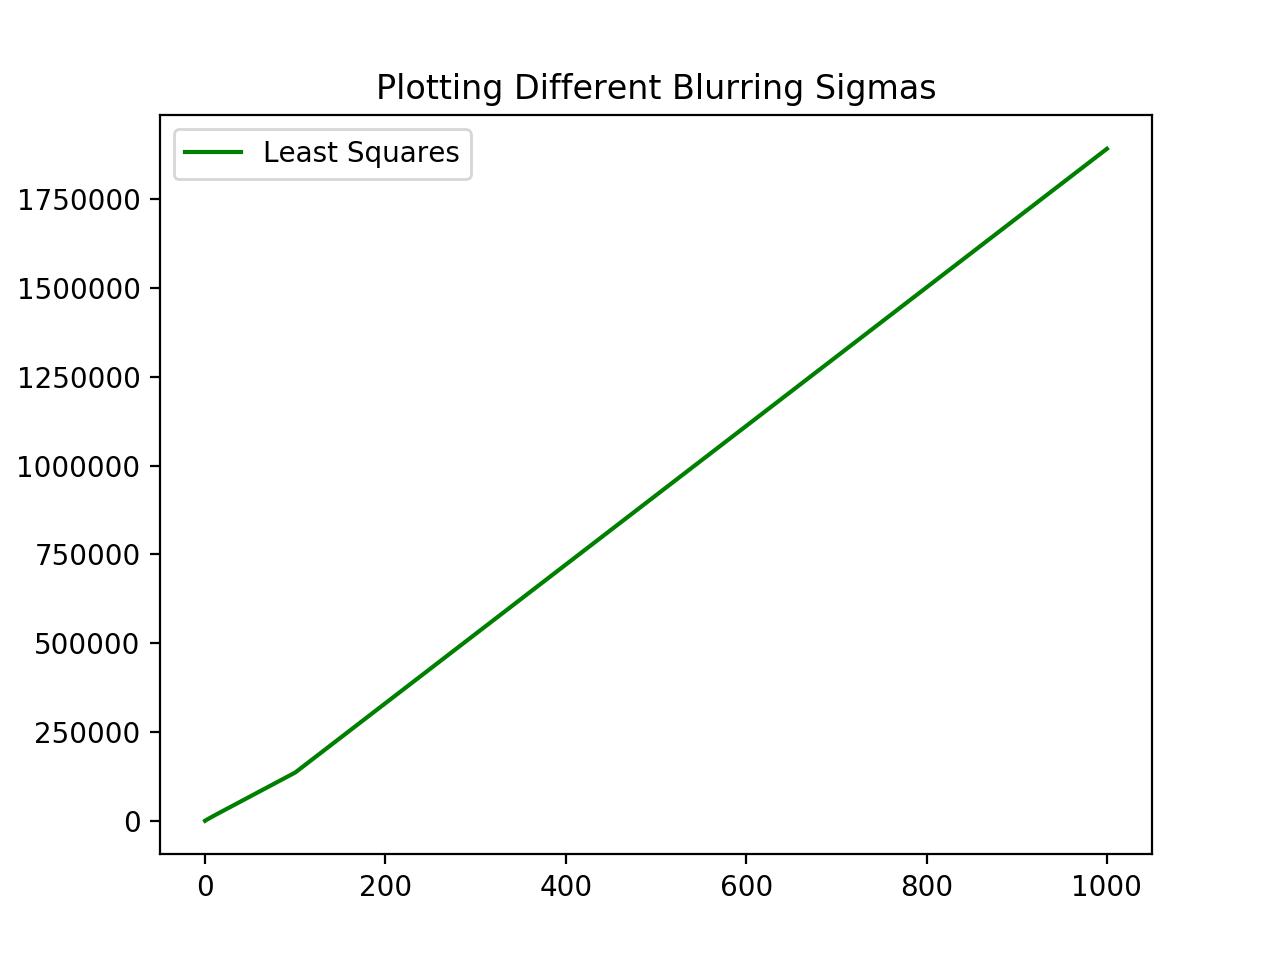

In [69]:
# plotting data from 3b

fig = plt.figure()
plt.title("Plotting Different Blurring Sigmas")
ls = plt.plot(sigmas,ls_sigs,color='green',label="Least Squares")
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()


[8, 8, 8, 8, 8, 8, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 5, 6, 6]


<IPython.core.display.Javascript object>


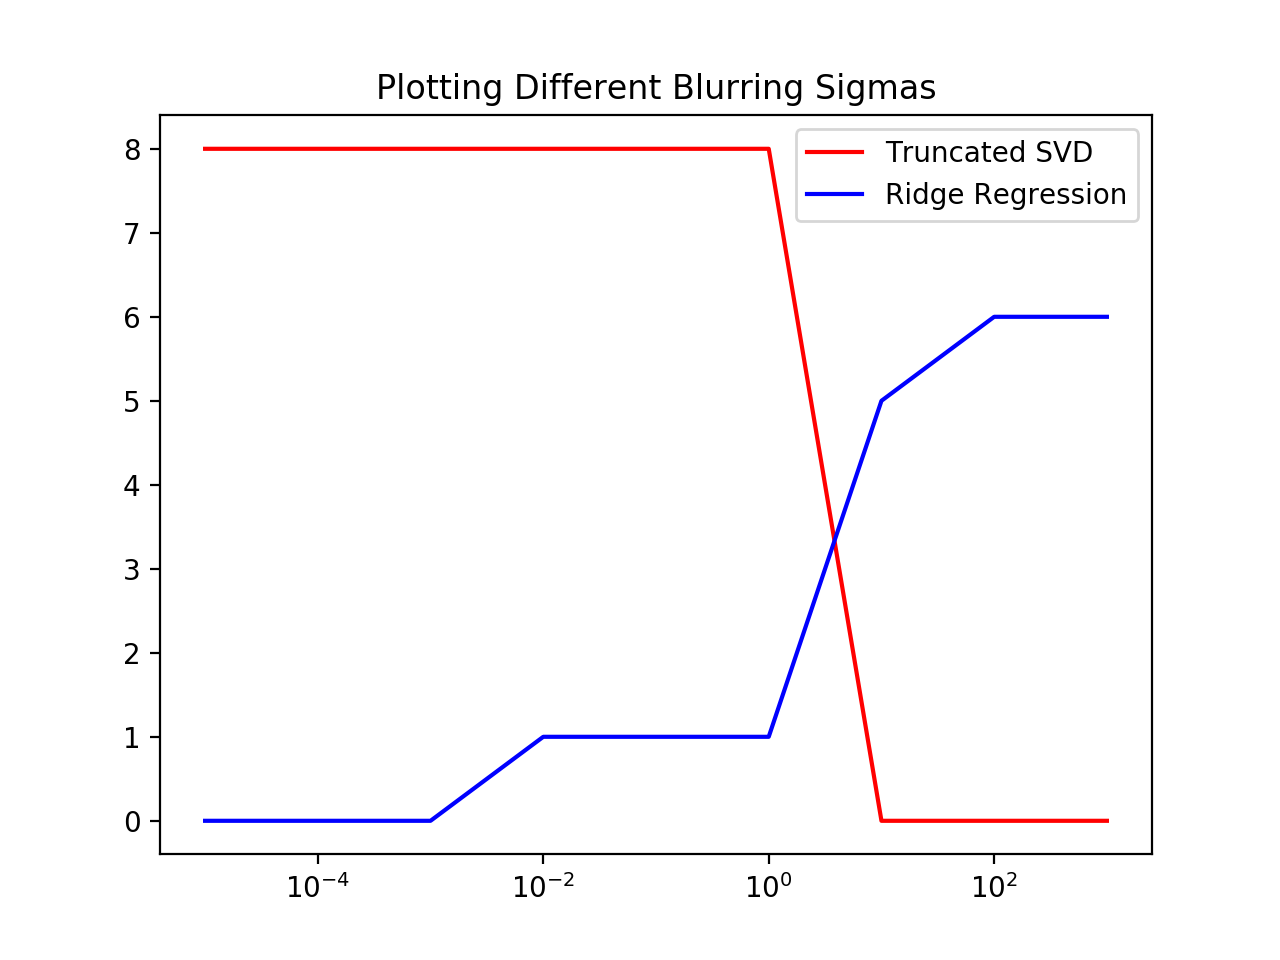

In [71]:
# plotting trunc SVD and RR

print(ks_sigs)
print(lams_sigs)

fig = plt.figure()
plt.title("Plotting Different Blurring Sigmas")
trunc_svd = plt.plot(sigmas,ks_sigs,color='red',label="Truncated SVD")
rr = plt.plot(sigmas,lams_sigs,color='blue',label="Ridge Regression")
plt.xscale("log")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


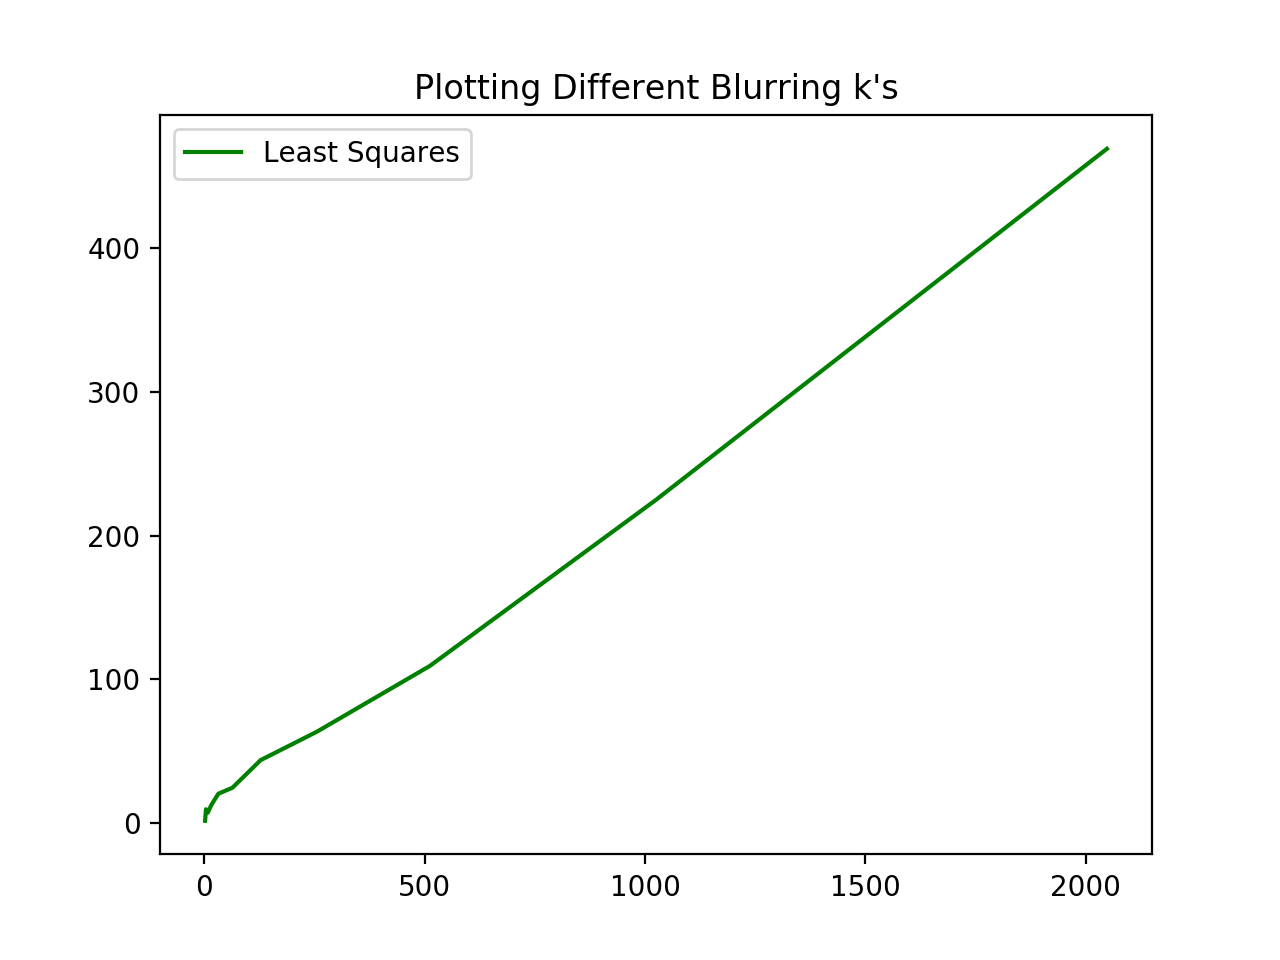

In [65]:
#plotting more data

fig = plt.figure()
plt.title("Plotting Different Blurring k's")
ls = plt.plot(blurr_ks,ls_bks,color='green',label="Least Squares")
plt.legend()
plt.show()

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


<IPython.core.display.Javascript object>


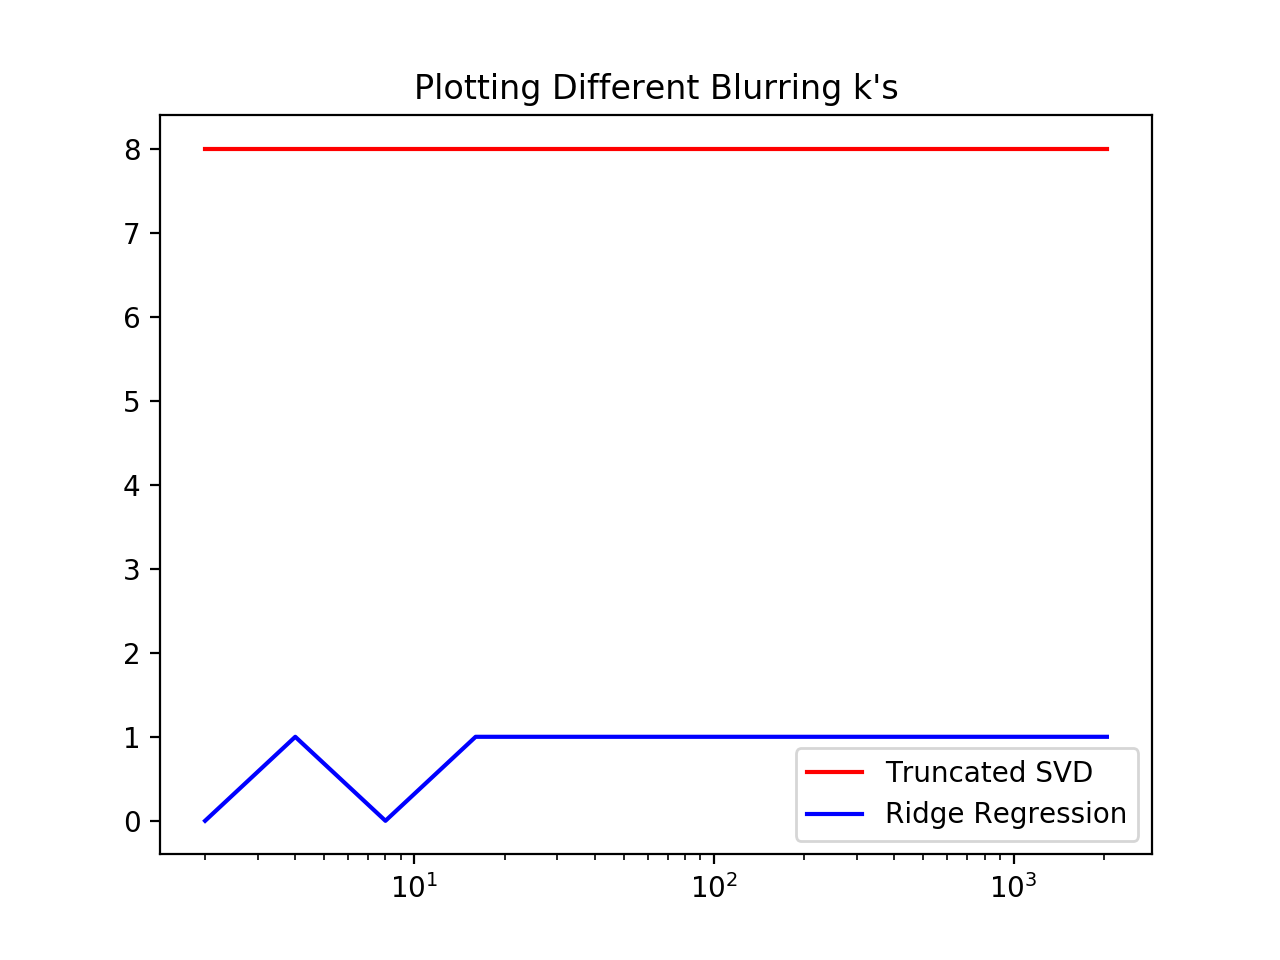

In [66]:
print(ks_bks)
print(lams_bks)

fig = plt.figure()
plt.title("Plotting Different Blurring k's")
trunc_svd = plt.plot(blurr_ks,ks_bks,color='red',label="Truncated SVD")
rr = plt.plot(blurr_ks,lams_bks,color='blue',label="Ridge Regression")
plt.xscale("log")
plt.legend()
plt.show()

# Problem 3b: Results

The error rates were used by calculating the norm difference between the calculated w and real w.

The k values in blurring did not have much affect on the truncated SVD or ridge regression parameters. However the simple least squares error increased linearly with k

The sigma values were a litte more interesting. The sigma values appeared to have a similar linear affect on the simple least squared error, but even with a relatively small sigma value, this error exploded. 
The truncated SVD and ridge regression were affected in a different way. For small errors, a lambda value close to zero (so, a small amount of tuning) and a very truncated SVD (only the largest singular values) was best. However, as sigma grew to the order of 10^1 and further, the parameters required quickly changed to need quite a bit of tuning, and more SVD data in order to produce the best result. This suggests that with noise, more data (more SVD), and more control of the data (more tuning) are preferred. As predicted, simple least squares is rather useless in noisey environments.

# Problem 5: PCR on MNIST

In [7]:
# Problem 5

def plot_distances(X,digit):
    u,sig,v = LA.svd(X,full_matrices=False)

    max_sig = min(X.shape)

    acc = [] #accuracies
    dim = []

    for i in range(2,16,2):
        a = 0
        for j in range(i+1,max_sig):
            a += sig[j]
        acc.append(math.sqrt(a))
        dim.append(i)

    fig = plt.figure()
    plt.scatter(dim,acc)
    plt.title("Average Distance of Digit {} by Dimension of Subspace".format(digit))
    plt.xlabel("Dimension")
    plt.ylabel("Distance")
    plt.show()
    
def plot_accuracy(X,digit):
    u,sig,vt = LA.svd(X,full_matrices=False)
    
    acc = [] #accuracies
    dim = [] # dimensions
    
    
    for i in range(2,16,2):
        sum_all = np.sum(np.square(sig))
        sum_k = np.sum(np.square(sig[0:i]))
        r = sum_k / sum_all
        acc.append(r)
        dim.append(i)

    fig = plt.figure()
    plt.plot(dim,acc)
    plt.title("Reconstruction Accuracy of Digit {} by Dimension of Subspace".format(digit))
    plt.xlabel("Dimension")
    plt.ylabel("Accuracy")
    plt.show()
    

# Problem 5a

<IPython.core.display.Javascript object>


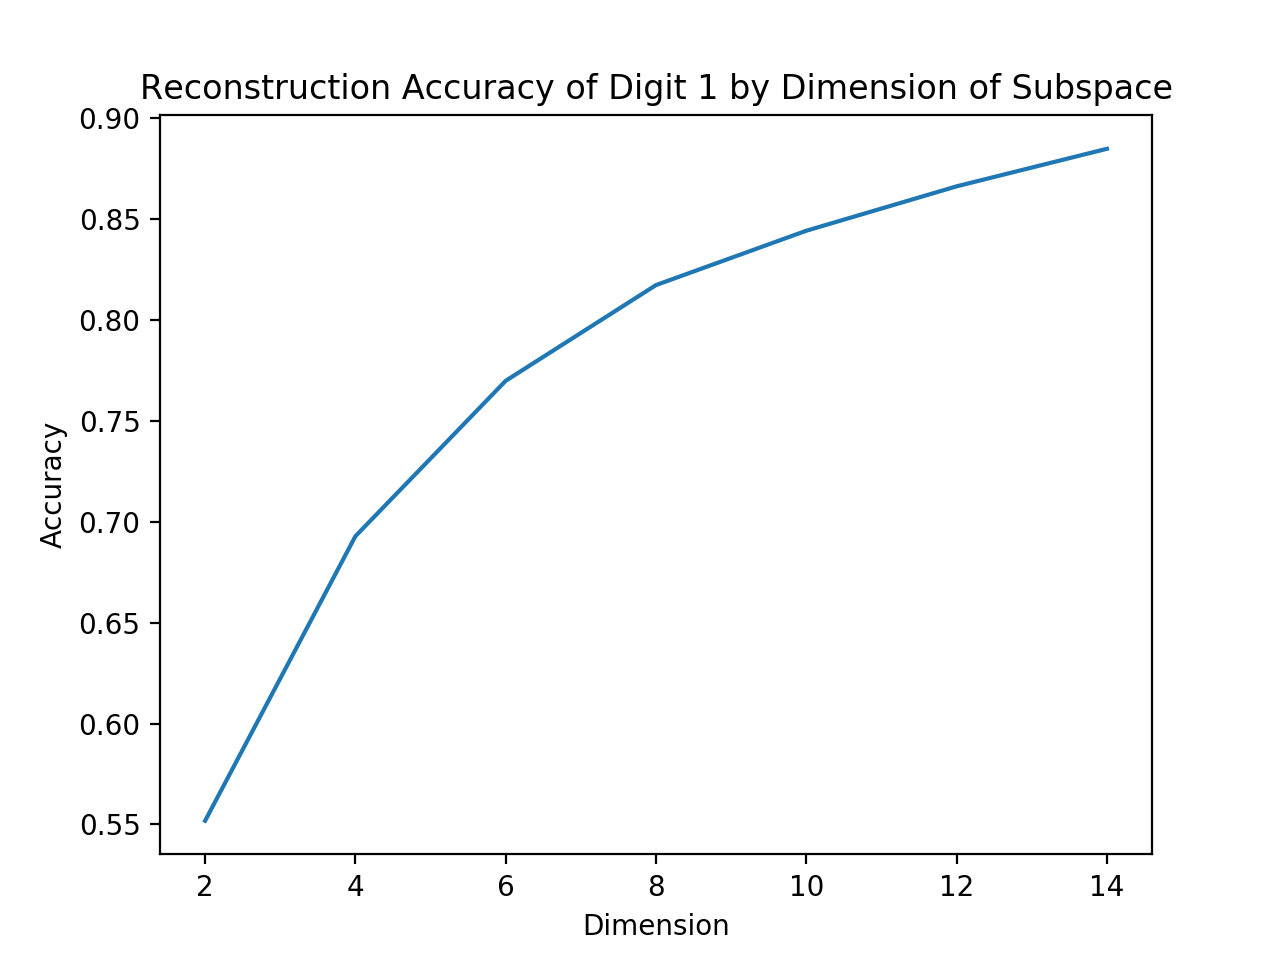

<IPython.core.display.Javascript object>


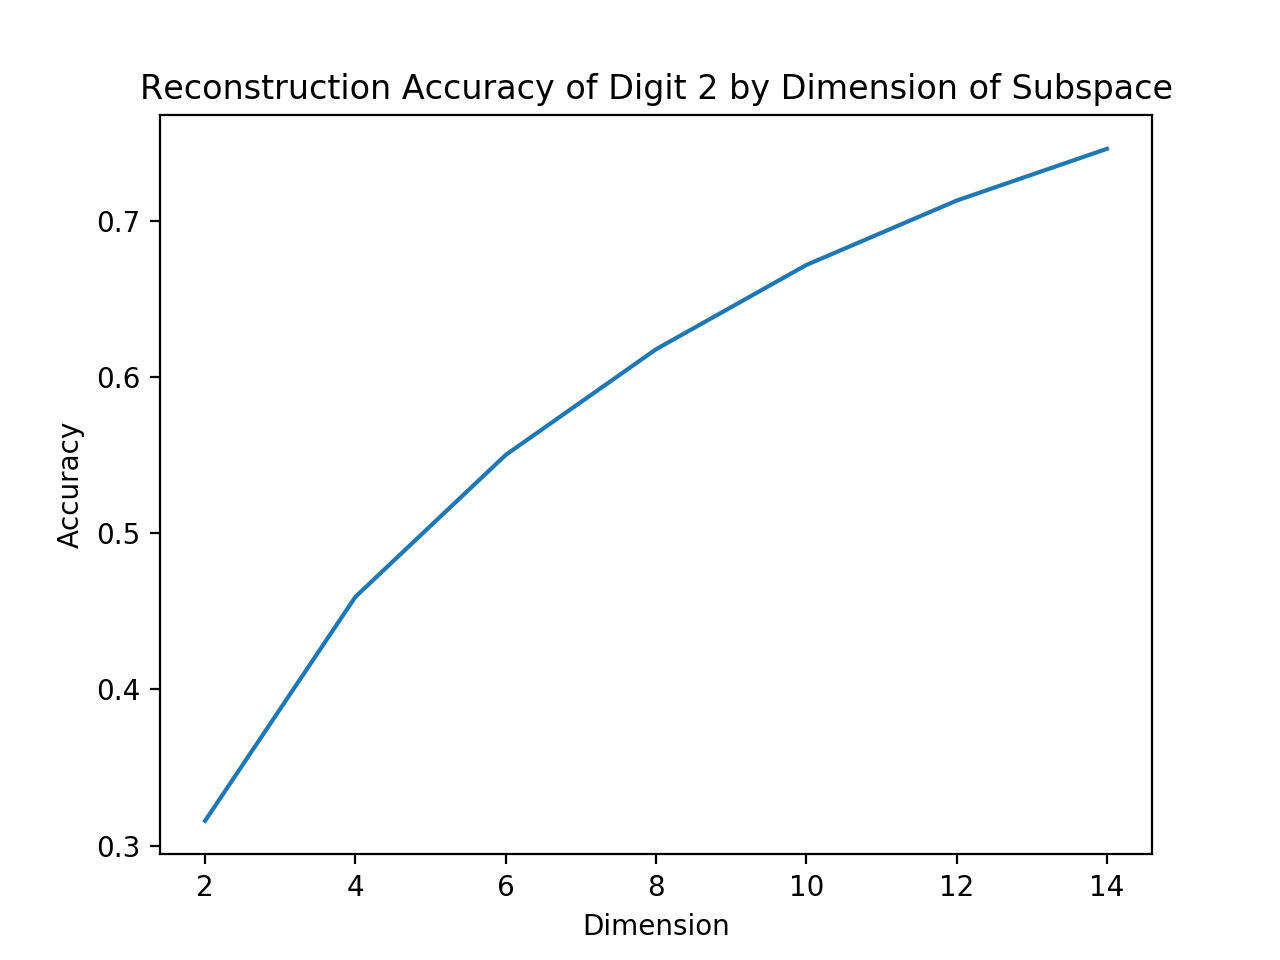

In [8]:
# Problem 5a

mnist = sio.loadmat('mnist.mat')
X = mnist['train_data']
X_test = mnist['test_data']
y_train = mnist['train_target']
y_test = mnist['test_target']

mean = X.mean(axis=0)
X = centralize(X)
X_test = X_test - mean

X1 = X[0:100]
X2 = X[100:200]

plot_accuracy(X1,1)
plot_accuracy(X2,2)


# Problem 5b

(200, 784)


<IPython.core.display.Javascript object>


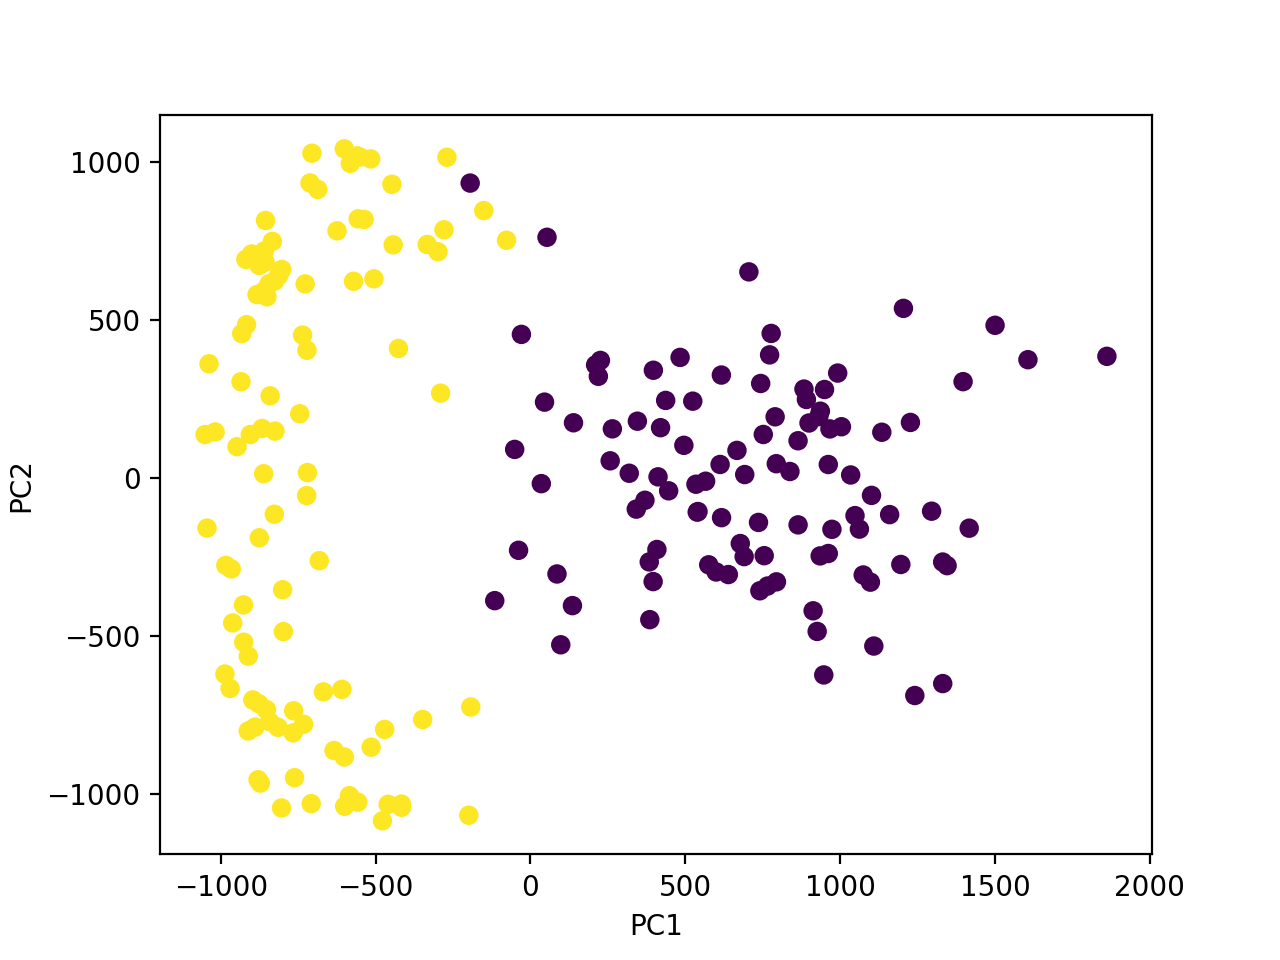

In [10]:
# Problem 5b

print(X.shape)

visualize_2d(X,y_train)

# Problem 5c

In [597]:
# Problem 5c: Linear Regression

u,sig,v = LA.svd(X)
Xd2 = X.dot(v.T[:,0:2])
X_test2 = X_test.dot(v.T[:,0:2])

w = least_squares(Xd2,y_train.T)

y_hat = X_test2.dot(w)

y_predict = np.sign(y_hat)
y_train_predict = np.sign(Xd2.dot(w))

train_err = np.mean(y_train_predict == y_train.T)

print("Training Accuracy: {}".format(train_err))
print("Test Accuracy: {}".format(err))



Training Accuracy: 0.975
Test Accuracy: 0.98


# Problem 5d

<IPython.core.display.Javascript object>


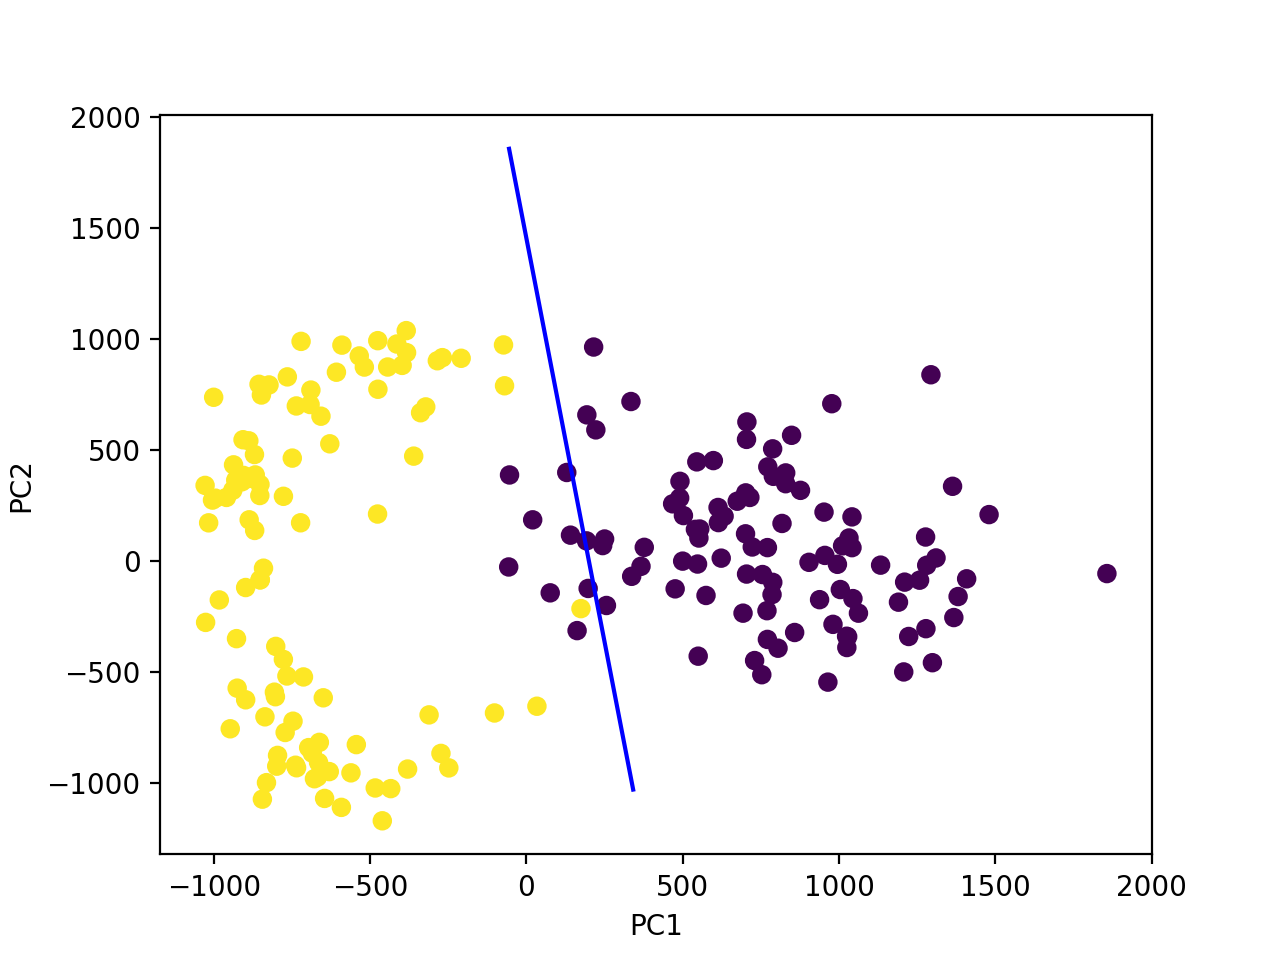

In [610]:
# Problem 5d

u,sig,v = LA.svd(X)
dim2 = X_test.dot(v.T[:,0:2])
max_val = np.argmax(dim2[:,0])
min_val = np.argmin(dim2[:,0])
plotme = np.zeros((2,2))
plotme[0] = dim2[min_val]
plotme[1] = dim2[max_val]

fig = plt.figure()
plt.scatter(dim2[:,0],dim2[:,1],c=y_test[0])
plt.plot(plotme[:,1],plotme[:,0],color='blue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


# Problem 6: PCA

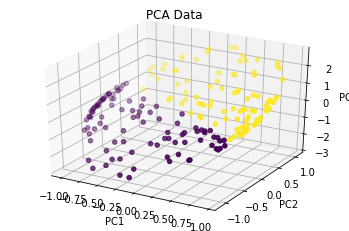

In [5]:
# Problem 6

#visualize data

pca = sio.loadmat('pca_3d.mat')
points = pca['point']

points = None
points = pca['point']
points = centralize(points)
x = points[:,0]
y = points[:,1]
z = points[:,2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
labels = pca['target']
ax.scatter3D(x,y,z,c=labels[0])
plt.title("PCA Data")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()




# Problem 6a

In [6]:
#Problem 6a


u,sig,v = LA.svd(points)


print("Axes: ")
print(v)
print("Singular values: ")
print(sig)



Axes: 
[[-0.08763198 -0.36226957 -0.92794472]
 [ 0.92287358  0.32114757 -0.21252907]
 [ 0.375      -0.875       0.30618622]]
Singular values: 
[1.69756107e+01 9.76874041e+00 1.95567816e-15]


According to the sigma values, all axes bear some importance, but the last axis is quite unimportant
The last axis is not non-zero, but is so close to zero it does not appear to be pertinent

# Problem 6b

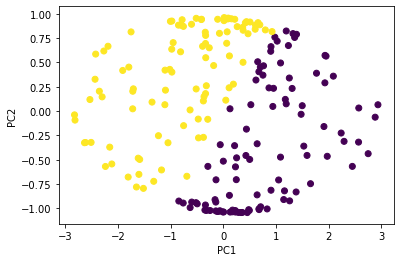

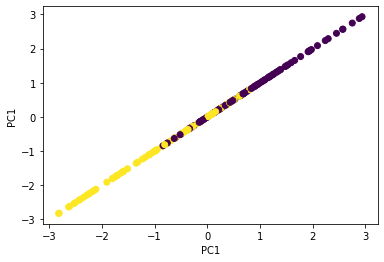

In [7]:
# Problem 6b

#visualize in 2d
d2 = points.dot(v.T[:,0:2])
fig = plt.figure()
plt.scatter(d2[:,0],d2[:,1],c=labels[0])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



#visualize in 1d
d1 = points.dot(v.T[:,0:1])
fig = plt.figure()
plt.scatter(d1[:,0],d1[:,0],c=labels[0])
plt.xlabel("PC1")
plt.ylabel("PC1")
plt.show()


# Problem 6c

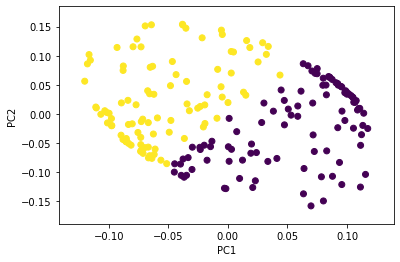

In [15]:
#Problem 6c

X = points[:,0:2]

lam,q = LA.eig(np.dot(X.T,X))

for i in range(len(lam)):
    lam[i] = 1/(math.sqrt(lam[i]))

lam = np.diag(lam)
W = np.dot(lam,q.T)  

X_tilde = np.dot(X,W.T)

u,sig,v = LA.svd(X_tilde)

d2_tilde = X_tilde.dot(v.T[:,0:2])
fig = plt.figure()
plt.scatter(d2_tilde[:,0],d2_tilde[:,1],c=labels[0])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


    

